# Fit *Chandra* HETG data with a powerlaw

This notebook gives an example of fitting *Chandra* HETG data with a simple power law model, using real spectrum files downloaded from *tgcat*.  We use the methods outlined in `ParTest_ProofOfConcept.ipynb`

We will fit the spectrum of the well-known blazar Mrk 421, which is frequently used as a *Chandra* calibration source.  This tutorial uses the data from ObsId 15477 obtained from tgcat (http://tgcat.mit.edu/)

Once you have downloaded the data files, unpack and unzip all the files in your directory of choice (`DATA_DIR`).  Don't forget to **modify the `DATA_DIR` string below** before running this tutorial.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

import os
import scipy.stats
from scipy.special import gammaln as scipy_gammaln
from scipy.optimize import minimize

import clarsach
import xpysis

%matplotlib inline

In [2]:
DATA_DIR = "/home/lia/dev/clarsach/data"
mrk_dir  = DATA_DIR + "/tgcat/obs_15477_tgid_4679/"
mrk_heg1_file = mrk_dir + "heg_1.pha"

## Set up model and statistics

Using Poisson statistics, the probability of getting a certain number of counts ($x$) given an expected model value of $m$ is:

$$ P (x | m) = \frac{m^x e^{-m}}{x!} $$

The log likelihood function is therefore

$$ \ln L = \ln \Pi_i P(x_i | m_i) = \Sigma_i \left[ x_i \ln m_i - m_i - \ln (x_i !) \right] = -K + \Sigma_i (x_i \ln m_i - m_i) $$

In this case, $K$ is a constant and can be ignored.

In order to *maximize* the likelihood, we want to maximize the value

$$ C' = \Sigma_i (x_i \ln m_i - m_i) $$

This is related to the well-known Cash statistic:

$$ C \equiv -2 \ln L = 2 \Sigma_i (m_i - x_i \ln m_i)  $$

so that $C' = -C / 2$

In [3]:
class PowerlawPoissonFit(clarsach.XSpectrum):
    def __init__(self, filename, **kwargs):
        clarsach.XSpectrum.__init__(self, filename, **kwargs)
        self.notice = np.zeros(len(self.bin_lo), dtype=bool)
        self.model  = clarsach.Powerlaw()
    
    def set_model_pars(self, pars):
        lognorm, pi = pars
        self.model.norm = np.power(10.0, lognorm)
        self.model.phoindex = pi
        
    # Model counts histogram
    def model_chist(self, pars):
        elo, ehi, emid, cts = self._change_units('keV')
        self.set_model_pars(pars)
        mflux = self.model.calculate(elo, ehi)
        result = self.apply_resp(mflux)
        return result
    
    def loglikelihood(self, pars):
        ymodel = self.model_chist(pars)
        ydata  = self.counts
        # compute the log-likelihood
        # How do I deal with zero values in my model? -- Ask Daniela
        cvals   = np.zeros(len(ymodel))
        ii      = (ymodel != 0.0)
        cvals[ii] = ydata[ii] * np.log(ymodel[ii]) - ymodel[ii]
        loglike = np.sum(cvals)
        
        if np.isfinite(loglike):
            return loglike
        else:
            return -np.inf
        
        return result

    def cash(self, pars):
        result = self.loglikelihood(pars)
        return -result/2.0
    
    ## Get residuals on the best fit
    def mod_residuals(self, pars):
        mcounts = self.model_chist(pars)
        cts_err = np.sqrt(self.counts)
        result  = np.zeros(len(self.counts))
        ii      = (cts_err != 0.0)
        result[ii] = (mcounts[ii] - self.counts[ii])/cts_err[ii]
        return result


In [4]:
mrk421 = PowerlawPoissonFit(mrk_heg1_file, telescope='HETG')

In [5]:
## Change the bin_units on the XSpectrum object to avoid confusion with arf and rmf units
mrk421.hard_set_units(mrk421.arf.e_unit)
print(mrk421.bin_unit)

keV


**Plot the data so we know it loaded okay**

Try switching the `xunit` keyword between 'keV' and 'angs'

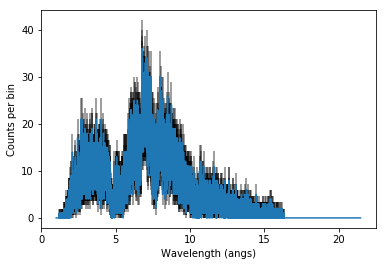

In [6]:
ax = plt.subplot(111)
xpysis.plot_counts(ax, mrk421, xunit='angs')

**Do a rough estimate of the flux spectrum by "unfolding" the counts histogram with the telescope response**

/home/lia/dev/xpysis/xpysis/plot.py:36: RuntimeWarning: invalid value encountered in divide
  eff_exp /= (spectrum.exposure * spectrum.arf.fracexpo)  # cm^2 s count / phot?


(0.5, 8.0)

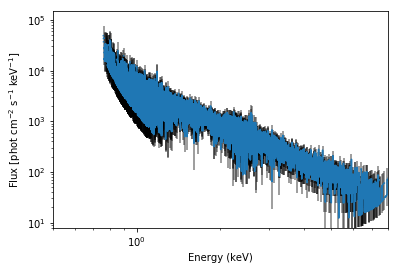

In [7]:
ax = plt.subplot(111)
xpysis.plot_unfold(ax, mrk421, xunit='keV')
plt.loglog()
plt.xlim(0.5,8.0)

## Start fitting

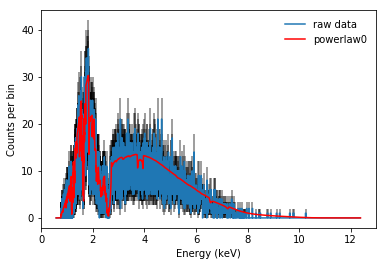

In [8]:
par0 = [-0.5, 2.5]  # Some starting parameters
mod0 = mrk421.model_chist(par0)

ax = plt.subplot(111)
xpysis.plot_counts(ax, mrk421, xunit='keV', label='raw data')
plt.plot(mrk421.bin_mid, mod0, 'r', label='powerlaw0')
plt.legend(loc='upper right', frameon=False)

In [9]:
mrk421.loglikelihood(par0)

49419.591672482689

In [10]:
mrk421.cash(par0)

-24709.795836241345

Now run scipy.optimize.minimize on the Cash statistic

In [ ]:
res = scipy.optimize.minimize(mrk421.cash, par0, method="L-BFGS-B")

In [ ]:
model_out = mrk421.model_chist(res.x)

ax = plt.subplot(111)
plt.plot(mrk421.bin_mid, mod0, 'r', label='powerlaw0')
plt.legend(loc='upper right', frameon=False)

In [ ]:
res_out = mrk421.mod_residuals(res.x)

fig = plt.figure(figsize=(6,6))
gs  = gridspec.GridSpec(2, 1, height_ratios=[2,1], hspace=0.0)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

pysis.plot_counts(ax1, mrk421, xunit='keV', label='Raw Data')
ax1.plot(mrk421.bin_mid, model_out, 'r', label='PL model')
ax1.legend(loc='upper right', frameon=False)

ax2.errorbar(mrk421.bin_mid, res_out, 
             xerr=0.5*(mrk421.bin_hi - mrk421.bin_lo), yerr=1.0,
             ls='', color='k', capsize=0, alpha=0.5)
ax2.axhline(0.0, color='k', ls=':')
ax2.set_ylabel(r'$\chi$')
ax2.set_xlabel('Energy (keV)')

ax1.xaxis.set_ticklabels('')
ax1.set_xlim(0.5,8.0)
ax2.set_xlim(0.5,8.0)

In [ ]:
mflux_out = mrk421.model.calculate(mrk421.bin_lo, mrk421.bin_hi) / (mrk421.bin_hi - mrk421.bin_lo)

ax = plt.subplot(111)
pysis.plot_unfold(ax, mrk421, xunit='keV')
pysis.plot_model_flux(ax, mrk421, mrk421.model, xunit='keV', color='r')
plt.loglog()